## This notebook shows how to use Orchestrator APIs for user experiments

In [54]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [55]:
bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

bastion_username = 'kissel'

bastion_key_filename = os.environ['HOME'] + "/.ssh/id_rsa"

ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()

In [56]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
#credmgr_host = "cm.fabric-testbed.net"
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
#orchestrator_host = "orchestrator.fabric-testbed.net"
print(f"FABRIC Orchestrator         : {orchestrator_host}")

print (ssh_key_pub)

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net
ssh-rsa AAAAB3NzaC1yc2EAAAABIwAAAQEAqJzOPz82FFxuEx7Q3XX+fnF2v/PXaUhNLxayzYsvooykhQjQw8NbLhmOSYxQ96H/yAv+TuxMrDse9A4FhUiz55bfTvf7vINg3FFxfXIdwAj82Q2ZPccdtFYcO0BQDGcCAjJPXXFBTdw1k8nnFN/zDyRwPArZKJ1RJWL+uochjSkKm3egASF2TBPJ1MpPvTfsG/IrXLJ2sH6Pa1oDPHnk5ZpU4OaKBW4vKjTcqqE3Pk8Qp+SpWKzc8ZMTtqeurWH8hzitUxuaxVMwmHIRM9iFg2MQIFGGIMCtqnY2Uqbf5CnlG52JRS0/MTSypd1FM3XqVCZJcchFZKJ7kBnt8bTd7Q== ezra@beesam


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [57]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [ ]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

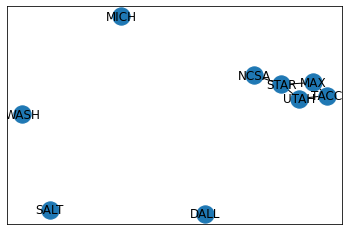

In [22]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice
In Release 1.0, user is expected to assign the IP addresses manually. Please use the example comands indicated below:

## Configure Slice Parameters



In [71]:
slice_name = 'MyTestSlice0'
site = 'UTAH'
worker = 'utah-w5.fabric-testbed.net'
nnodes = 8
network_service_name='bridge1'
username = 'ubuntu'
image = 'default_ubuntu_20'
image_type = 'qcow2'
cores = 2
ram = 8
disk = 10

In [72]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType, Labels
# Create topology
t = ExperimentTopology()

# Specify exact component if set
labels = Labels()
if worker:
    labels.instance_parent = worker

# Add nodes
for i in range(0, nnodes):
    nname = f"node{i}"
    nic_name = f"{nname}-nic1"
    
    node = t.add_node(name=nname, site=site)
    
    # Set capacities
    cap = Capacities()
    cap.set_fields(core=cores, ram=ram, disk=disk)

    # Set Properties
    node.set_properties(capacities=cap, image_type=image_type, image_ref=image, labels=labels)

    # Shared Cards
    node.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name=nic_name)

# L2Bridge Service
t.add_network_service(name=network_service_name, nstype=ServiceType.L2Bridge, interfaces=t.interface_list)

# Generate Slice Graph
slice_graph = t.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")

Submitted slice creation request. Slice ID: 9336ddc2-0854-4361-984c-117d54024020


## Get the Slice

In [73]:
import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice    


return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice ............ Slice state: StableOK

Slice Name : MyTestSlice0
ID         : 9336ddc2-0854-4361-984c-117d54024020
State      : StableOK
Lease End  : 2022-01-12 16:17:18


## Get the Nodes

Retrieve the node information and save the management IP address.


### Get the Topology

In [74]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

In [80]:
slivers = slice_manager.slivers(slice_object=slice)
print (slivers)

(<Status.OK: 1>, [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000008e1\", \"instance_parent\": \"utah-w5.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "65c23c67-2b60-4d85-95ca-a02d6b26c408",
    "join_state": "NoJoin",
    "labels": "{\"instance_parent\": \"utah-w5.fabric-testbed.net\"}",
    "lease_end": "2022-01-12 16:17:18",
    "management_ip": "2001:1948:417:7:f816:3eff:fe2e:fc22",
    "name": "node2",
    "notices": "Reservation 75572c06-8e93-4d04-9f65-dc7ae24b4a2e (Slice MyTestSlice0(9336ddc2-0854-4361-984c-117d54024020) Graph Id:0229b669-3e7b-40a6-b028-158981f976ee Owner:name: orchestrator guid: orchestrator-guid email: kissel@es.net State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_stat

### Configure Nodes

Use ssh to configure the shared NIC in each VM

In [77]:
node_addrs = list()
for i in range(0, nnodes):
    nname = f"node{i}"
    node = experiment_topology.nodes[nname]

    management_ip = str(node.get_property(pname='management_ip'))
    print("Node Name        : {}".format(node.name))
    print("Management IP    : {}\n".format(management_ip))
    node_addrs.append(management_ip)

Node Name        : node0
Management IP    : 2001:1948:417:7:f816:3eff:fed3:65d3

Node Name        : node1
Management IP    : 2001:1948:417:7:f816:3eff:fec1:9330

Node Name        : node2
Management IP    : 2001:1948:417:7:f816:3eff:fe2e:fc22

Node Name        : node3
Management IP    : 2001:1948:417:7:f816:3eff:fed0:1615

Node Name        : node4
Management IP    : 2001:1948:417:7:f816:3eff:fe54:ba30

Node Name        : node5
Management IP    : 2001:1948:417:7:f816:3eff:fe0b:55ec

Node Name        : node6
Management IP    : 2001:1948:417:7:f816:3eff:feba:2d02

Node Name        : node7
Management IP    : 2001:1948:417:7:f816:3eff:fe30:3e6c



In [78]:
from ipaddress import ip_address, IPv4Address
def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

import paramiko
key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

bastion=paramiko.SSHClient()
bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)
bastion_transport = bastion.get_transport()

i = 1
for addr in node_addrs:
    if validIPAddress(addr) == 'IPv4':
        src_addr = (bastion_private_ipv4_addr, 22)
    elif validIPAddress(addr) == 'IPv6':
        src_addr = (bastion_private_ipv6_addr, 22)
    else:
        print('Management IP Invalid: {}'.format(addr))
        continue

    dest_addr = (addr, 22)
    bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)

    client = paramiko.SSHClient()
    client.load_system_host_keys()
    client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

    client.connect(addr,username=username,pkey = key, sock=bastion_channel)
    
    print (f"Setting iface config on {addr} (node{i-1})")
    stdin, stdout, stderr = client.exec_command(f"sudo ip addr add 192.168.10.{i}/24 dev ens7")
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    stdin, stdout, stderr = client.exec_command('sudo ip link set ens7 up && ip addr show dev ens7')
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    client.close()
    i += 1

Setting iface config on 2001:1948:417:7:f816:3eff:fed3:65d3 (node0)

3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 02:13:80:a3:dc:9d brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.1/24 scope global ens7
       valid_lft forever preferred_lft forever
    inet6 fe80::13:80ff:fea3:dc9d/64 scope link tentative 
       valid_lft forever preferred_lft forever

Setting iface config on 2001:1948:417:7:f816:3eff:fec1:9330 (node1)

3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    link/ether 02:aa:1f:20:41:a6 brd ff:ff:ff:ff:ff:ff
    inet 192.168.10.2/24 scope global ens7
       valid_lft forever preferred_lft forever
    inet6 fe80::aa:1fff:fe20:41a6/64 scope link tentative 
       valid_lft forever preferred_lft forever

Setting iface config on 2001:1948:417:7:f816:3eff:fe2e:fc22 (node2)

3: ens7: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP group default qlen 1000
    lin

In [81]:
# Ping from node0 to the others
addr = node_addrs[0]

dest_addr = (addr, 22)
bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)

client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

client.connect(addr,username=username,pkey = key, sock=bastion_channel)

for i in range(1, nnodes+1):
    stdin, stdout, stderr = client.exec_command(f"ping -c 2 192.168.10.{i}")
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

PING 192.168.10.1 (192.168.10.1) 56(84) bytes of data.
64 bytes from 192.168.10.1: icmp_seq=1 ttl=64 time=0.038 ms
64 bytes from 192.168.10.1: icmp_seq=2 ttl=64 time=0.012 ms

--- 192.168.10.1 ping statistics ---
2 packets transmitted, 2 received, 0% packet loss, time 1029ms
rtt min/avg/max/mdev = 0.012/0.025/0.038/0.013 ms

PING 192.168.10.2 (192.168.10.2) 56(84) bytes of data.
64 bytes from 192.168.10.2: icmp_seq=1 ttl=64 time=0.118 ms
64 bytes from 192.168.10.2: icmp_seq=2 ttl=64 time=0.108 ms

--- 192.168.10.2 ping statistics ---
2 packets transmitted, 2 received, 0% packet loss, time 1003ms
rtt min/avg/max/mdev = 0.108/0.113/0.118/0.005 ms

PING 192.168.10.3 (192.168.10.3) 56(84) bytes of data.

--- 192.168.10.3 ping statistics ---
2 packets transmitted, 0 received, 100% packet loss, time 1026ms


PING 192.168.10.4 (192.168.10.4) 56(84) bytes of data.
64 bytes from 192.168.10.4: icmp_seq=1 ttl=64 time=0.094 ms
64 bytes from 192.168.10.4: icmp_seq=2 ttl=64 time=0.113 ms

--- 192.16

## Delete Slice

In [68]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
